In [1]:
import numpy as np
from PIL import Image
import pandas as pd
%config Completer.use_jedi = False

In [2]:
!ls ../raw_data/

all_ones_benchmark.csv          images_training_rev1
all_zeros_benchmark.csv         test_sample
central_pixel_benchmark.csv     train_sample
galaxy-zoo-the-galaxy-challenge training_solutions_rev1.csv
images_test_rev1                zips


In [3]:
image_train_names = !ls ../raw_data/images_training_rev1/ #loading images_names.jpg to list
df_image_train_names = pd.DataFrame(image_train_names)  
df_image_train_names = df_image_train_names.rename(columns={0:'image'}) 
df_training_solutions_rev1 = pd.read_csv('../raw_data/training_solutions_rev1.csv')
#loading y dataframe
print(df_training_solutions_rev1.shape, len(image_train_names)) #checking lenghts

(61578, 38) 61578


In [4]:
array_y_train = np.array(df_training_solutions_rev1.drop(columns=['GalaxyID']))
y_train_scaled_array = np.array([array_y_train[i]/array_y_train[i].sum() for i in range(len(array_y_train))])
print(y_train_scaled_array[110].sum())
df_y_train_scaled = pd.DataFrame(y_train_scaled_array, columns=list(df_training_solutions_rev1.drop(columns=['GalaxyID'])))
df_y_train_scaled.head(2)

1.0


,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.066729,0.107432,0.000000,0.000000,0.107432,0.006697,0.100735,0.072869,0.034563,0.0,...,0.000000,0.048757,0.024112,0.000000,0.0,0.016177,0.0,0.0,0.0,0.056692
1,0.051975,0.105503,0.001466,0.004956,0.100547,0.074285,0.026262,0.093988,0.006560,0.0,...,0.002982,0.000000,0.020882,0.073106,0.0,0.093988,0.0,0.0,0.0,0.000000


In [5]:
df_y_train_scaled['image'] = df_image_train_names['image']
df_y_train_scaled.head(2)

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,image
0,0.066729,0.107432,0.000000,0.000000,0.107432,0.006697,0.100735,0.072869,0.034563,0.0,...,0.048757,0.024112,0.000000,0.0,0.016177,0.0,0.0,0.0,0.056692,100008.jpg
1,0.051975,0.105503,0.001466,0.004956,0.100547,0.074285,0.026262,0.093988,0.006560,0.0,...,0.000000,0.020882,0.073106,0.0,0.093988,0.0,0.0,0.0,0.000000,100023.jpg


In [6]:
df_X_y_sample = df_y_train_scaled.sample(400)
df_X_y_sample.shape

(400, 38)

In [7]:
df_X_y_train = df_X_y_sample[:200]
df_X_y_test = df_X_y_sample[201:]

In [8]:
import tensorflow as tf

def load_image(image):
    '''returns one image'''
    folder = f'../raw_data/images_training_rev1/{image}'
    img = Image.open(folder)
    img_array = np.array(img)
    return np.resize(img_array, (224,224,3))
    
def load_images(df):
    '''returns array of images'''
    img_list = []
    for _, row in df.iterrows():
        img = load_image(row["image"])
        img_list.append(img) 
    return np.stack(img_list)

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size=64, shuffle=True, ):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __len__(self):
        '''returns number of minibatches per epoch'''
        return len(self.indices) // self.batch_size
    
    def on_epoch_end(self):
        '''shuffles the indices '''
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
            
    def __get_X_image(self, df):
        '''returns images'''
        X = load_images(df)
        return X 
             
    def __get_Y(self, df):
        '''returns y'''
        return np.array(df.drop(columns=["image"]))
    
    def _get_data(self, batch):
        '''returns batch of images and y'''
        df_batch = self.df.query("index in @batch") 
        X = self.__get_X_image(df_batch)
        y = self.__get_Y(df_batch)
        return X, y
    
    def __getitem__(self, index):
        '''creates batches and returns final X and y'''
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        X, y = self._get_data(batch)
        return X, y

In [9]:
datagenerator_train = DataGenerator(df=df_X_y_train, shuffle=True)
datagenerator_test = DataGenerator(df=df_X_y_test, shuffle=True)

In [10]:
import keras 
import tensorflow.keras as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, Concatenate
from keras import Sequential
from tensorflow.keras.models import Model

# telechargement modèle ResNet50
base_model = keras.applications.ResNet50(
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_top=False
            )
# freeze 
for layer in base_model.layers[:200]:
    layer.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training =True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(37, activation='linear')(x)
cnn_model = keras.Model(inputs=inputs, outputs=x)

In [11]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 37)                75813     
Total params: 23,663,525
Trainable params: 75,813
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
cnn_model.compile(loss='mse',  #loss a voir
              optimizer='adam',
              metrics='mse')

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3, restore_best_weights=True )

In [14]:
cnn_model.fit(datagenerator_train, batch_size=2, epochs=500, callbacks=es, verbose=1, validation_data=datagenerator_test)


Epoch 1/500
3/3 [==============================] - 45s 18s/step - loss: 2.3455 - mse: 2.3455 - val_loss: 0.6305 - val_mse: 0.6305
Epoch 2/500
3/3 [==============================] - 48s 20s/step - loss: 1.0102 - mse: 1.0102 - val_loss: 0.4415 - val_mse: 0.4415
Epoch 3/500
3/3 [==============================] - 52s 22s/step - loss: 0.8669 - mse: 0.8669 - val_loss: 0.4409 - val_mse: 0.4409
Epoch 4/500
3/3 [==============================] - 48s 20s/step - loss: 0.8560 - mse: 0.8560 - val_loss: 0.3316 - val_mse: 0.3316
Epoch 5/500
3/3 [==============================] - 48s 20s/step - loss: 0.6860 - mse: 0.6860 - val_loss: 0.2303 - val_mse: 0.2303
Epoch 6/500
3/3 [==============================] - 46s 19s/step - loss: 0.5763 - mse: 0.5763 - val_loss: 0.1932 - val_mse: 0.1932
Epoch 7/500
3/3 [==============================] - 47s 19s/step - loss: 0.5503 - mse: 0.5503 - val_loss: 0.1877 - val_mse: 0.1877
Epoch 8/500
3/3 [==============================] - 46s 19s/step - loss: 0.5079 - mse: 0.50

In [15]:
evaluation = cnn_model.evaluate(datagenerator_test)

3/3 [==============================] - 24s 8s/step - loss: 0.0598 - mse: 0.0598


In [26]:
np.sqrt(evaluation[0])

0.2445857529639654

In [17]:
image = df_y_train_scaled.sample(1)[['image']]
image_jpg = np.array(image)[0][0]

In [18]:
predict = cnn_model.predict(load_images(image))

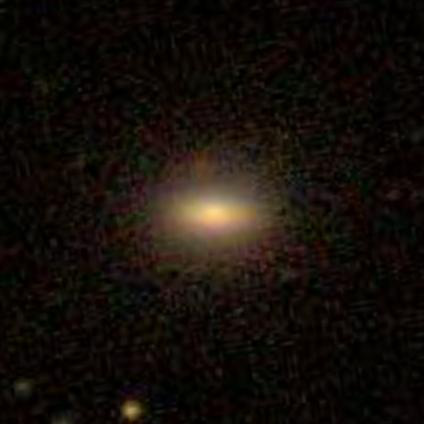

In [20]:
Image.open(f'../raw_data/images_training_rev1/{image_jpg}')

In [22]:
df_y_train_scaled[df_y_train_scaled['image']==image_jpg]

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6,image
24316,0.160898,0.096436,0.000982,0.041371,0.055065,0.039003,0.016063,0.0,0.055065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,455046.jpg


In [25]:
df_y_train_scaled_noimage = df_y_train_scaled.drop(columns=['image'])
pd.DataFrame(predict, columns=list(df_y_train_scaled_noimage.columns))

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.286372,-0.120835,-0.144949,-0.078027,0.200853,-0.141642,0.211532,0.058227,-0.064328,-0.013974,...,-0.123593,-0.044217,-0.300199,0.023504,-0.229077,-0.013914,-0.335904,-0.119802,-0.075836,-0.205957


In [1]:
output = array[1:]
output.shape

#liste qui va récupérer les paths
decision_answer = []

def cat1():
#cat1 : what does it look like ?
    
    smooth = output[0]
    #df['Class1.1']
    feature_or_disk = output[1]
    #df['Class1.2']
    star = output[2]
    #df['Class1.3']
    
    if smooth > feature_or_disk:
        #go to cat 7
        decision_answer.append('smooth')
        cat7()
                
    elif star > smooth or star > feature_or_disk:
            #STOP --> étoile
        print("c'est une étoile")
                
    else:
    #feature_or_disk > all:
            #go to class 2
        decision_answer.append('feature_or_disk')
        cat2()
                  
    return decision_answer

def cat2():
#cat2 : featureordisk --> could this be a disk view edge-on ?
    
    edgeon_yes = output[3] 
    #df['Class2.1']
    edgeon_no = output[4]
    #df['Class2.2']

    if edgeon_yes > edgeon_no:
        #go to cat 9
        decision_answer.append('edgeon_yes')
        cat9()
        
    else:
        #edgeon_no> edgeon_yes
        decision_answer.append('edgeon_no')
        #go to cat 3
        cat3()
        
    return decision_answer


def cat3():
#cat 3 : featureordisk --> edgeon_no --> is there a sign of bar feature ?
    
    bar_yes = output[5]
    #df['Class3.1']
    bar_no = output[6] 
    #df['Class3.2']
    
    #all : go to cat 4
    if bar_yes > bar_no:
        decision_answer.append('bar_yes')
        cat4()
        
    else:
        #bar_no > bar_yes
        decision_answer.append('bar_no')
        cat4()
    
    return decision_answer

 

def cat4():
#cat4 : featureordisk --> no --> bar_yes/no --> spiral arm pattern ?

    arm_yes = output[7]
    #df['Class4.1']
    arm_no = output[8]
    #df['Class4.2']

    if arm_yes > arm_no:
        #go to cat10
        decision_answer.append('arm_yes')
        cat10()

    else:
        #arm_yes > arm_no
        decision_answer.append('arm_no')
        #go to cat5
        cat5()
    
    return decision_answer       


def cat5():
#cat5 : prominence of central buldge ?
#featureordisk --> edgeon_no --> bar_yes/no --> arm_no
#featureordisk --> edgeon_no --> --> bar_yes/no --> arm_yes --> all arms sizes --> all number of arms

    no_bulge = output[9]
    #df['Class5.1']
    noticeable_bulge = output[10]
    #df['Class5.2']
    obvious_bulge = output[11]
    #df['Class5.3']
    dominant_bulge = output[12]
    #df['Class5.4']

#all: go to cat 6
    if no_bulge > noticeable_bulge and no_bulge > obvious_bulge and no_bulge > dominant_bulge:
        decision_answer.append('no_bulge')
        cat6()
        
    elif noticeable_bulge > no_bulge and noticeable_bulge > obvious_bulge and noticeable_bulge > dominant_bulge:
        decision_answer.append('noticeable_bulge')
        cat6()
        
    elif obvious_bulge > no_bulge and obvious_bulge > noticeable_bulge and obvious_bulge > dominant_bulge:
        decision_answer.append('obvious_bulge')
        cat6()
        
    else:
        #dominant_bulge > all
        decision_answer.append('dominant_bulge')
        cat6()

    
    return decision_answer  


def cat6():
#cat6 - is there anything odd ?
#featureordisk --> edgeon_no --> bar_yes/no --> arm_no --> all
#Smooth --> class 7 : all
#featureordisk --> edgeon_yes --> class 9 :all

    odd_yes = output[13]
    #df['Class6.1']
    odd_no = output[14]
    #df['Class6.2']

    if odd_yes > odd_no:
        #go to cat 8
        decision_answer.append('odd_yes')
        cat8()    

    else:
        decision_answer.append('odd_no')
        #stop

    return decision_answer


#DEUXIEME CHEMIN

def cat7():
    #cat7 : Smooth - how rounded is it ?
    completely_round = output[15]
    #df['Class7.1']
    in_between = output[16]
    #df['Class7.2']
    cigar_shaped = output[17]
    #df['Class7.3']

#all: go to cat6
    if completely_round > in_between and completely_round > cigar_shaped:
        decision_answer.append('completely_round')
        cat6()

    elif in_between > completely_round and in_between > cigar_shaped:
        decision_answer.append('in_between')
        cat6()
    
    else:
        #cigar_shaped > all
        decision_answer.append('cigar_shaped')
        cat6()

    return decision_answer


def cat8():
    #cat8 : featureordisk --> edgeon_no --> bar_yes/no --> arm_no --> all --> odd_yes --> ring, 
    #disturber or irregular ?

    ring = output[18]
    #df['Class8.1']
    lens_or_arc = output[19]
    #df['Class8.2']
    disturbed = output[20]
    #df['Class8.3']
    irregular = output[21]
    #df['Class8.4']
    other = output[22]
    #df['Class8.5']
    merger = output[23]
    #df['Class8.6']
    dust_lane = output[24]
    #df['Class8.7']

    #all: stop
    if ring > lens_or_arc and ring > disturbed and ring > irregular and ring > other and ring > merger and ring > dust_lane:
        decision_answer.append('ring')
        #stop
    
    elif lens_or_arc > ring and lens_or_arc > disturbed and lens_or_arc > irregular and lens_or_arc > other and lens_or_arc > merger and lens_or_arc > dust_lane:
        decision_answer.append('lens_or_arc')
        #stop
    
    elif disturbed > lens_or_arc and disturbed > ring and disturbed > irregular and disturbed > other and disturbed > merger and disturbed > dust_lane:
        decision_answer.append('disturbed')
        #stop

    elif irregular > lens_or_arc and irregular > disturbed and irregular > ring and irregular > other and irregular > merger and irregular > dust_lane:
        decision_answer.append('irregular')
        #stop
        
    elif other > lens_or_arc and other > disturbed and other > irregular and other > ring and other > merger and other > dust_lane:
        decision_answer.append('other')
        #stop
        
    elif merger > lens_or_arc and merger > disturbed and merger > irregular and merger > other and merger > ring and merger > dust_lane:
        decision_answer.append('merger')
        #stop
    
    else:
        #dust_lane > all
        decision_answer.append('dust_lane')
        #stop
    return decision_answer



def cat9():
    #cat9 : featureordisk --> edgeon_yes --> if there a bulge, if yes what shape ?
    
    rounded = output[25]
    #df['Class9.1']
    boxy = output[26]
    #df['Class9.2']
    no_bulge2 = output[27]
    #df['Class9.3']

# all: go to cat6
    if rounded > boxy and rounded > no_bulge2:
        decision_answer.append('rounded')
        cat6()

    elif boxy > rounded and boxy > no_bulge2:
        decision_answer.append('boxy')
        cat6()
    
    else:
        #no_bulge2 > all
        decision_answer.append('no_bulge2')
        cat6()

    return decision_answer



def cat10():
    #cat10 : featureordisk --> edgeon_no --> bar_yes/no --> arm_yes --> how tights are the arms ?
    
    tight = output[28]
    #df['Class10.1']
    medium = output[29]
    #df['Class10.2']
    loose = output[30]
    #df['Class10.3']

#all: go to cat 11
    if tight > medium and tight > loose:
        decision_answer.append('tight')
        #cat11()

    elif medium > tight and medium > loose:
        decision_answer.append('medium')
        #cat11()
        
    else:
        #loose > all
        decision_answer.append('loose')       
        #cat11()
        
    return decision_answer



def cat11():
#cat 11: featureordisk --> edgeon_no --> bar_yes/no --> arm_yes --> all arms sizes --> how many arms ?
    
    one_arm = output[31]
    #df['Class11.1']
    two_arms = output[32]
    #df['Class11.2']
    three_arms = output[33]
    #df['Class11.3']
    four_arms = output[34]
    #df['Class11.4']
    more_than_four_arms = output[35]
    #df['Class11.5']
    cant_tell_arms = output[36]
    #df['Class11.6']

#all: go to cat5
    if one_arm > two_arms and one_arm > three_arms and one_arm > four_arms and one_arm > more_than_four_arms and one_arm > cant_tell_arms:
        decision_answer.append('one_arm')
        cat5()

    elif two_arms > one_arm and two_arms > three_arms and two_arms > four_arms and two_arms > more_than_four_arms and two_arms > cant_tell_arms:
        decision_answer.append('two_arms')
        cat5()
        
    elif three_arms > one_arm and three_arms > two_arms and three_arms > four_arms and three_arms > more_than_four_arms and three_arms > cant_tell_arms:
        decision_answer.append('three_arms')
        cat5()  
        
    elif four_arms > one_arm and four_arms > three_arms and four_arms > two_arms and four_arms > more_than_four_arms and four_arms > cant_tell_arms:
        decision_answer.append('four_arms')
        cat5()
        
    elif more_than_four_arms > one_arm and more_than_four_arms > three_arms and more_than_four_arms > four_arms and more_than_four_arms > two_arms and more_than_four_arms > cant_tell_arms:
        decision_answer.append('more_than_four_arms')
        cat5()
    
    else:
        #cant_tell_arms > all
        decision_answer.append('cant_tell_arms')
        cat5()
        
        
    return decision_answer


cat1()

NameError: name 'array' is not defined